In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import glob
import itertools
import pickle
from scipy import signal
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:

def calibrate_camera():
    """
    this method will calibrate the camera
    """
    images = glob.glob('camera_cal/*.jpg')

    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    x = 1280 # image length
    y=720 # image height

    for idx, fname in enumerate(images):
        img = mpimg.imread(fname)
        ## resize the image if it isn't the same shape
        if img.shape[0] != x:
            img = cv2.resize(img,(x,y), interpolation = cv2.INTER_CUBIC)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        for nx,ny in itertools.permutations(range(9,4,-1),2):
            objp = np.zeros((nx*ny,3), np.float32)
            objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
            if ret:
                break
        objpoints.append(objp)
        imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (y, x),None,None)
    return mtx, dist

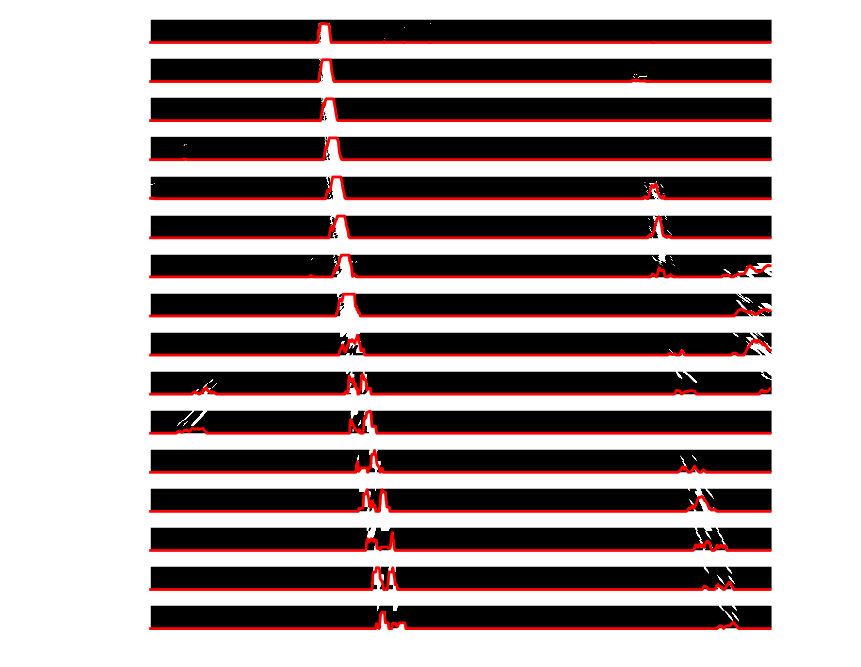

In [21]:
pixel_height = [i for i in range(warped_image.shape[0],0,-45)]
hist_ranges = [(pixel_height[i+1],pixel_height[i]) if i+1 < len(pixel_height) else (0,pixel_height[i]) for i in range(len(pixel_height)) ]
i = 0
plt.figure(figsize=(10, 10))
for pixel_range in hist_ranges:
    new_image = warped_image[pixel_range[0]:pixel_range[1],:]
    hist = np.sum(new_image, axis=0)
    plt.subplot(20, 1, i+1)
    plt.axis('off')
    var_holder = plt.imshow(new_image,cmap='gray')
    plt.plot(hist,color='red',linewidth=2)
    plt.gca().invert_yaxis()
    i+=1
plt.show()
new_img = warped_image[hist_ranges[1][0]:hist_ranges[1][1],:]
#plt.imshow(new_img,cmap='gray')

In [5]:
#prev_left_line, prev_right_line = None, None
def process_image(image,mtx=mtx,dist=dist):
    global prev_left_line, prev_right_line
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    threshold_image = get_threshold_image(image)
    image_center = int(image.shape[1]/2)
    max_y_value = int(image.shape[0]/1.5)
    center_left = (image_center - .22 * int(image.shape[1]/2), max_y_value )
    bottom_left = (image_center - .9 * int(image.shape[1]/2), image.shape[0])
    center_right = (image_center + .22 * int(image.shape[1]/2), max_y_value )
    bottom_right = (image_center + .9 * int(image.shape[1]/2), image.shape[0])
    src = np.float32([[center_left[0],center_left[1]],[center_right[0],center_right[1]],
                  [bottom_right[0],bottom_right[1]],[bottom_left[0],bottom_left[1]]])
    dst = np.float32([[0,0],[image.shape[1],0],[image.shape[1],image.shape[0]],[0,image.shape[0]]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped_image = cv2.warpPerspective(threshold_image, M, (threshold_image.shape[1],threshold_image.shape[0]))
    pixel_height = [i for i in range(warped_image.shape[0],0,-45)]
    hist_ranges = [(pixel_height[i+1],pixel_height[i]) if i+1 < len(pixel_height) else (0,pixel_height[i]) for i in range(len(pixel_height)) ]
    right_line,left_line = LineBuilder(warped_image.shape),LineBuilder(warped_image.shape)
    for i, j in zip(hist_ranges, range(len(hist_ranges))):
        hist = np.sum(warped_image[i[0]:i[1],:], axis=0)
        non_zero_x_loc = np.where(hist>0)[0]

        ##right line
        if j < 1 or not right_line.has_any_points():
            right_side = non_zero_x_loc[non_zero_x_loc > image_center]
            right_line.add_point(i[0], right_side)
        else:
            right_line.add_point(i[0], non_zero_x_loc)
        ## left line
        if j < 1 or not left_line.has_any_points():
            left_side = non_zero_x_loc[non_zero_x_loc < image_center]
            left_line.add_point(i[0], left_side)
        else:
            left_line.add_point(i[0], non_zero_x_loc)
    if left_line.get_polynomial() != None and right_line.get_polynomial() != None:
        prev_left_line, prev_right_line = left_line, right_line
    else:
        left_line, right_line = prev_left_line, prev_right_line
    left_fit = left_line.get_polynomial()
    right_fit = right_line.get_polynomial()
    yvals = np.linspace(0, 100, num=101)*warped_image.shape[0]
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    inv = cv2.getPerspectiveTransform(dst,src)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    inv = cv2.getPerspectiveTransform( dst, src)
    newwarp = cv2.warpPerspective(color_warp, inv, (image.shape[1], image.shape[0])) 
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0) 
    return result
            
#images = glob.glob('test_images/*.jpg')
#image = mpimg.imread(images[1])
#plt.imshow(process_image(image))

NameError: name 'mtx' is not defined

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import itertools
import pickle
from scipy import signal
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    This function will return the absolute value of the sobel derivative
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    else:
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return grad_binary
    
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    This function will compute the magnitude of the gradient and apply a threshold
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    magnitude = np.sqrt((sobelx**2) +(sobely**2))
    normalized = magnitude/np.max(magnitude)
    normalized_unit_8 = np.uint8(255*normalized)
    mag_binary = np.zeros_like(normalized_unit_8)
    mag_binary[(normalized_unit_8 > mag_thresh[0]) & (normalized_unit_8 < mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    This function will calculate the direction of the gradient and 
    create a binary mask where direction thresholds are met
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
    arctan = np.arctan2(sobely, sobelx)
    dir_binary = np.zeros_like(arctan)
    dir_binary[(arctan > thresh[0]) & (arctan < thresh[1])] = 1
    return dir_binary

def hls_s_thresh(image,thresh = (175, 255)):
    """
    This function will thresholds the S-channel of HLS image
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def get_threshold_image(image):
    """
    This function will return a thresholded image where most of the image noise
    is removed and the lanes are clearly visiable.
    """
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=5, thresh=(30, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=5, thresh=(30, 100))
    mag_binary = mag_thresh(image, sobel_kernel=5, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=5, thresh=(0.7, 1.3))
    hls_thresh = hls_s_thresh(image,thresh = (175, 255))
    combined = np.zeros_like(hls_thresh)
    combined[((gradx == 1) & (grady == 1))|hls_thresh == 1 | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

class LineBuilder():
    
    def __init__(self, image_shape):
        self.confident_points = []
        self.unconfident_points = []
        self.points_skipped = 0
        self.image_height = image_shape[0]
        self.image_width = image_shape[1]
    
    def add_point(self, y_loc, hist, prev_fit = None):
        """
        This method is used to add a point to the line
        @y_loc - the max y location from this histogram
        @hist - a histogram from the thresholded image (at location y_loc) where the values are greater than 0
        @prev_fit - s polynomial fit from the previous frame
        """
        ## if there are no detected points - ignore this y_loc
        if len(hist) <= 1:
            self.points_skipped += 1
            return
        ## if this is the first point detected for this line and there is no line from the previous frame -
        ## calculate the points and add it to the list
        if not self.has_any_points() and prev_fit == None:
            hist = self.reject_outliers(hist)
            if len(hist) <= 1:
                self.points_skipped += 1
                return
            left_point, right_point, confident_score,distance = self.calculate_points(y_loc, hist)
            self.add_point_to_list(left_point, right_point, confident_score,distance )
        ## if it isn't the first point for this line but there is no line from the previous frame -
        ## use the last found point of this line as a starting point for this y_loc
        elif prev_fit == None:
            last_point = self.get_last_point()
            adjusted_pixels = (self.points_skipped +1) * 25
            hist = np.array([i for i in hist if last_point[0][0]-adjusted_pixels < i < last_point[1][0]+adjusted_pixels])
            hist = self.reject_outliers(hist)
            if len(hist) <= 1:
                self.points_skipped += 1
                return
            left_point, right_point, confident_score,distance = self.calculate_points(y_loc, hist)
            self.add_point_to_list(left_point, right_point, confident_score,distance )
        ## if there is a line from the previous frame - use that line to calculate the current line location
        else:
            prev_poly = np.poly1d(prev_fit)
            prev_x_loc = prev_poly(y_loc)
            adjusted_pixels = 25
            hist = np.array([i for i in hist if prev_x_loc-adjusted_pixels < i < prev_x_loc+adjusted_pixels])
            hist = self.reject_outliers(hist)
            if len(hist) <= 1:
                self.points_skipped += 1
                return
            left_point, right_point, confident_score,distance = self.calculate_points(y_loc, hist)
            self.add_point_to_list(left_point, right_point, confident_score,distance )
            
    def calculate_points(self, y_loc, hist):
        """
        This function will calculate the points for this y location.
        since the histogram is a list of all x locations where the image pixel values were greater than the threshold,
        the x location will be computed by finding the max and min x location from the historgam
        """
        max_x = max(hist)
        min_x = min(hist)
        confident_score = len(hist)/ (max_x-min_x+1)
        return (min_x, y_loc), (max_x, y_loc), confident_score,(max_x-min_x+1)
    
    def add_point_to_list(self,left_point, right_point, confident_score,distance ):
        """
        This function will add the points to it's appropriate list
        if the confident score is greater than 40 % and the width of the line is between 25 and 40 pixels,
        the point will be added to the confident_points list, otherwise it will be added to the unconfident_points list
        """
        if confident_score > .4 and 55 > distance > 10:
            self.confident_points.append((left_point,right_point))
            self.points_skipped = 0
        elif distance < 75: ##reject weird points
            self.unconfident_points.append((left_point,right_point))
            self.points_skipped += 1
    
    def has_any_points(self):
        return len(self.confident_points) >= 1
    
    def get_last_point(self):
        return self.confident_points[-1]
    
    def reject_outliers(self, data, m=1.5):
        """
        this method will reject ouliers from a historam
        """
        if len(data) <= 2:
            return data
        if (max(data) - min(data)) < 30: ##TODO: why 30 ?
            return data
        d = np.abs(data - np.median(data))
        mdev = np.median(d)
        s = d/mdev if mdev else 0.
        return data[s<m]
    
    def get_squared_error(self):
        poly_func = np.poly1d(self.get_polynomial())
        squared_error = []
        for left_point,right_point in self.confident_points:
            mid_x_point = ((right_point[0]-left_point[0] )/2.0) + left_point[0]
            squared_error.append((mid_x_point - poly_func(right_point[1]))**2)
        return sum(squared_error) **.5
    
    def get_polynomial(self, in_meters=False):
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        
        all_confident_points = self.get_all_confident_points()
        
        if len(all_confident_points) < 1:
            return None
        
        max_confident_y = max(all_confident_points, key=lambda x: x[1])[1]
        min_confident_y = min(all_confident_points, key=lambda x: x[1])[1]
        
        all_x = [i[0]*xm_per_pix if in_meters else i[0] for i in all_confident_points]
        all_y = [i[1]*ym_per_pix if in_meters else i[1]  for i in all_confident_points]
        if len(self.confident_points) >= 3 and max_confident_y - min_confident_y > self.image_height/5:
            return np.polyfit( all_y,all_x, 2)
        else:
            for left_point,right_point in self.unconfident_points:
                mid_x_point = ((right_point[0]-left_point[0] )/2.0) + left_point[0]
                if in_meters:
                    all_x.append(mid_x_point*xm_per_pix)
                    all_y.append(right_point[1]*ym_per_pix)
                else:
                    all_x.append(mid_x_point)
                    all_y.append(right_point[1])
            return np.polyfit( all_y,all_x, 2)
        
        
    def get_confident_score(self):
        return len(self.confident_points) / (self.image_height / 40 )

    def get_all_confident_points(self):
        all_points = [i[0] for i in self.confident_points]
        all_points.extend([i[1] for i in self.confident_points])
        return all_points
    
    def get_curvature(self):
        poly_in_meters = self.get_polynomial(in_meters=True)
        return ((1 + (2*poly_in_meters[0]*self.image_height + poly_in_meters[1])**2)**1.5) / np.absolute(2*poly_in_meters[0])
    
class LaneBuilder():
    def __init__(self, mtx, dist):
        self.mtx = mtx
        self.dist = dist
        self.image_shape = None
        self.yvals = None
        self.skipped = 0
        self.image_center = None
        self.last_left_line, self.last_right_line = None, None
        self.confident_left_fit, self.confident_right_fit = None, None
    
    def process_image(self, image):
        """
        This method will take an image, undistort it, caclulate the lane lines, and return the processed image.
        """
        if self.image_shape == None:
            self.image_shape = image.shape
            self.yvals = np.linspace(0, 100, num=101)*self.image_shape[0]
            self.image_center = int(self.image_shape[1]/2)
        ## first step: undistort the image
        undistorted_image = cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
        
        ## next step: remove most of the noise and get a thresholded image
        threshold_image = get_threshold_image(undistorted_image)
        
        ## next step: get a birds eye view of the lanes
        src, dst = self.get_mask_space()
        M = cv2.getPerspectiveTransform(src, dst)
        warped_image = cv2.warpPerspective(threshold_image, M, (threshold_image.shape[1],threshold_image.shape[0]))
        
        ## next step: calculate the left and right line
        left_line, right_line = self.build_lines(warped_image)
        left_fit, right_fit = self.get_polynomial( left_line, right_line)
        left_fitx = left_fit[0]*self.yvals**2 + left_fit[1]*self.yvals + left_fit[2]
        right_fitx = right_fit[0]*self.yvals**2 + right_fit[1]*self.yvals + right_fit[2]
        
        ## next step: color the lane
        warp_zero = np.zeros_like(warped_image).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        pts_left = np.array([np.transpose(np.vstack([left_fitx, self.yvals]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, self.yvals])))])
        pts = np.hstack((pts_left, pts_right))
        inv = cv2.getPerspectiveTransform(dst,src)
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        inv = cv2.getPerspectiveTransform( dst, src)
        newwarp = cv2.warpPerspective(color_warp, inv, (undistorted_image.shape[1], undistorted_image.shape[0])) 
        result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
        
        ## next step: print the curvature
        font = cv2.FONT_HERSHEY_SIMPLEX
        if left_line.get_polynomial() != None and right_line.get_polynomial() != None:
            left_curvature, right_curvature = left_line.get_curvature(), right_line.get_curvature()
            avg_curvature = (left_curvature+ right_curvature)/2
            cv2.putText(result,"lane curvature {0:.02f} meters ".format(avg_curvature) ,(10,50), font,  1,(255,255,255),2)
        cv2.putText(result,"car is {0:.02f} meters from center of lane".format(self.image_location_from_center(left_fit, right_fit)) ,(10,100), font,  1,(255,255,255),2)
        return result
    
    def get_polynomial(self, left_line, right_line):
        using_last_line = False
        ## if something went wrong when building the line - use old line
        if left_line.get_polynomial() == None or right_line.get_polynomial() == None:
            left_line, right_line = self.last_left_line ,self.last_right_line
            using_last_line = True
            self.skipped += 1

        ## if the error on the last right line is too big - use the last line
        if self.confident_right_fit != None:
            error_to_last_right = np.sqrt(np.sum((right_line.get_polynomial() - self.confident_right_fit)**2)/ np.sum(self.confident_right_fit**2))
        elif self.last_right_line != None:
            last_right_poly = self.last_right_line.get_polynomial()
            error_to_last_right = np.sqrt(np.sum((right_line.get_polynomial() - last_right_poly)**2)/ np.sum(last_right_poly**2))
        else:
            error_to_last_right = 0
        
        ##Assign polynomial
        if error_to_last_right > (self.skipped+1)*0.05 and not using_last_line and  self.confident_right_fit != None:
            left_fit, right_fit = self.confident_left_fit, self.confident_right_fit
            self.skipped += 1
        elif self.confident_right_fit != None:
            right_fit = .1 * right_line.get_polynomial() +.9 * self.confident_right_fit
            left_fit =  .1 * left_line.get_polynomial() +.9 * self.confident_left_fit
        else:
            left_fit, right_fit = left_line.get_polynomial(), right_line.get_polynomial()
        
        #Assign confident polynomial
        if left_line.get_squared_error() < 20 and right_line.get_squared_error() < 20 and not using_last_line and \
            self.lines_are_mostly_parallel(left_fit, right_fit) and error_to_last_right < (self.skipped+1)*0.05:
            self.confident_left_fit, self.confident_right_fit = left_fit, right_fit
        
        ## Assign last line
        self.last_left_line, self.last_right_line = left_line, right_line

        if self.skipped > 5:
            self.confident_left_fit, self.confident_right_fit = None, None
            self.skipped = 0
        return left_fit, right_fit

    def get_mask_space(self):
        """
        this method returns the src and destination of an image to warp it
        """
       
        max_y_value = int(self.image_shape[0]/1.5)
        center_left = (self.image_center - .22 * int(self.image_shape[1]/2), max_y_value )
        bottom_left = (self.image_center - .9 * int(self.image_shape[1]/2), self.image_shape[0])
        center_right = (self.image_center + .22 * int(self.image_shape[1]/2), max_y_value )
        bottom_right = (self.image_center + .9 * int(self.image_shape[1]/2), self.image_shape[0])
        src = np.float32([[(self.image_shape[1] / 2) - 75, self.image_shape[0] / 2 + 100],
            [((self.image_shape[1] / 6) - 10), self.image_shape[0]],
            [(self.image_shape[1] * 5 / 6) + 60, self.image_shape[0]],
            [(self.image_shape[1] / 2 + 75), self.image_shape[0] / 2 + 100]])
        dst = np.float32([[((self.image_shape[1] / 4) -150), 0],[((self.image_shape[1] / 4)-150), self.image_shape[0]],
            [((self.image_shape[1] * 3 / 4)+150), self.image_shape[0]],[((self.image_shape[1] * 3 / 4)+150), 0]])

        #src = np.float32([[center_left[0],center_left[1]], [center_right[0],center_right[1]],
         #             [bottom_right[0],bottom_right[1]], [bottom_left[0],bottom_left[1]]])
        #dst = np.float32([[0,0], [self.image_shape[1],0],
        #                  [self.image_shape[1],self.image_shape[0]], [0,self.image_shape[0]]])

        ###src = np.float32([[585, 460], [203, 720],[1127, 720], [695, 460]])
        ###dst = np.float32([[320, 0], [320, 720], [960, 720], [960, 0]])
        
        return src, dst
    
    def build_lines(self, image):
        pixel_height = [i for i in range(image.shape[0],0,-40)]
        hist_ranges = [(pixel_height[i+1],pixel_height[i]) if i+1 < len(pixel_height) else (0,pixel_height[i]) for i in range(len(pixel_height)) ]
        right_line,left_line = LineBuilder(image.shape),LineBuilder(image.shape)
        for i, j in zip(hist_ranges, range(len(hist_ranges))):
            hist = np.sum(image[i[0]:i[1],:], axis=0)
            non_zero_x_loc = np.where(hist>0)[0]

            ##right line
            if not right_line.has_any_points() and self.confident_right_fit == None:
                right_side = non_zero_x_loc[non_zero_x_loc > self.image_center]
                right_line.add_point(i[0], right_side)
            else:
                right_line.add_point(i[0], non_zero_x_loc, self.confident_right_fit)
            ## left line
            if not left_line.has_any_points() and self.confident_left_fit == None:
                left_side = non_zero_x_loc[non_zero_x_loc < self.image_center]
                left_line.add_point(i[0], left_side)
            else:
                left_line.add_point(i[0], non_zero_x_loc, self.confident_left_fit)
        return left_line, right_line
    
    def lines_are_mostly_parallel(self, left_fit, right_fit):
        """
        this method will check if the lines are mostly parallel.
        
        since the warped image isn't exactly proportional, this method will just ensure that
        there is a proper distance between the 2 lines and that the distance is becoming smaller as the
        y axis increases.
        """
        prev_distance = None
        left_poly = np.poly1d(left_fit)
        right_poly = np.poly1d(right_fit)
        for i in range(0,self.image_shape[0],10):
            distance = right_poly(i) -(right_poly(i)-left_poly(i))
            if prev_distance == None and 175 < distance < 425:
                prev_distance = distance
            elif prev_distance != None and abs(prev_distance-distance) < 5:
                prev_distance = distance
            else:
                return False
        return True
    
    def image_location_from_center(self, left_fit, right_fit):
        left_poly, right_poly = np.poly1d(left_fit), np.poly1d(right_fit)
        left_side, right_side = left_poly(self.image_shape[0]),right_poly(self.image_shape[0])
        lane_center = ((right_side - left_side)/2) + left_side
        image_center = self.image_center
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        return (lane_center - self.image_center) * xm_per_pix


In [62]:
video_file = VideoFileClip( 'project_video.mp4')
video_file.save_frame('frame_2.jpg', t=1)

In [2]:
project_output = 'project_output.mp4'
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
#mtx, dist = calibrate_camera()
lane_builder = LaneBuilder(mtx, dist)

video_file = VideoFileClip( 'project_video.mp4')
vid = video_file.fl_image(lane_builder.process_image)
%time vid.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:03<00:00,  5.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

Wall time: 4min 4s


[[  565.           460.        ]
 [  203.33332825   720.        ]
 [ 1126.66662598   720.        ]
 [  715.           460.        ]] [[  170.     0.]
 [  170.   720.]
 [ 1110.   720.]
 [ 1110.     0.]]
True


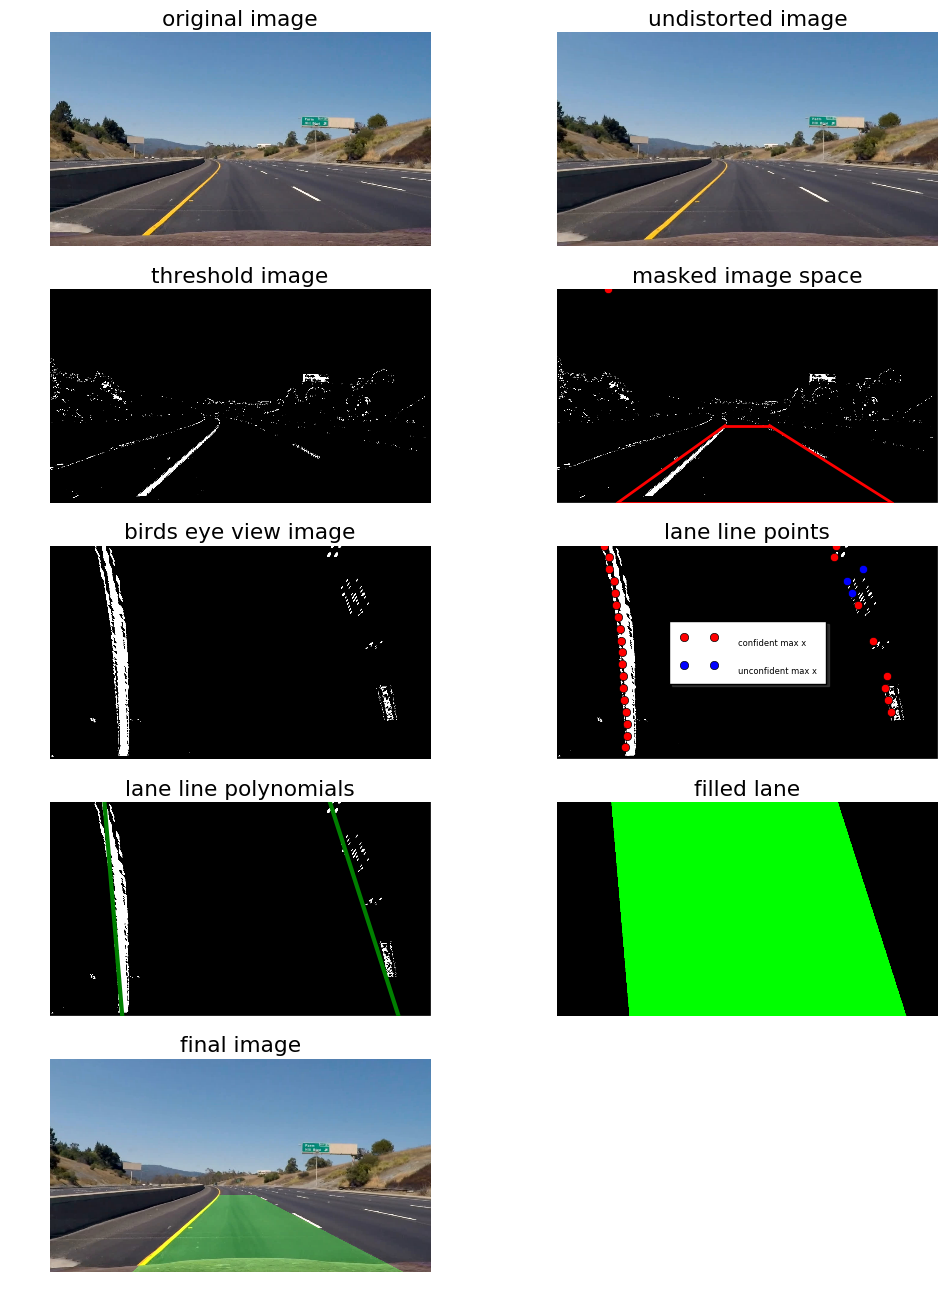

In [3]:
image = mpimg.imread('frame_2.jpg')
lane_builder = LaneBuilder(mtx, dist)
final_image = lane_builder.process_image(image)
final_image = lane_builder.process_image(image)
src, dst = lane_builder.get_mask_space()
print(src,dst)
undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
image_shape = undistorted_image.shape
M = cv2.getPerspectiveTransform(src, dst)
threshold_image = get_threshold_image(undistorted_image)
warped_image = cv2.warpPerspective(threshold_image, M, (threshold_image.shape[1],threshold_image.shape[0]))

plt.figure(figsize=(12, 16))
plt.rcParams.update({'font.size': 13})
plt.subplot(5, 2, 1)
plt.title("original image")
plt.axis('off')
var_holder = plt.imshow(image)
plt.subplot(5, 2, 2)
plt.title("undistorted image")
plt.axis('off')
var_holder = plt.imshow(undistorted_image)
plt.subplot(5, 2, 3)
plt.title("threshold image")
plt.axis('off')
var_holder = plt.imshow(threshold_image, cmap='gray')
plt.subplot(5, 2, 4)
plt.title("masked image space")
plt.axis('off')
plt.xlim(0, warped_image.shape[1])
plt.ylim(0, warped_image.shape[0])
plt.gca().invert_yaxis()
var_holder = plt.imshow(threshold_image, cmap='gray')
plt.plot([src[0][0], src[1][0]],[src[0][1], src[1][1]], '-',color='r', linewidth=2)
plt.plot(dst[0][0],dst[0][1],  'o',color='r')
plt.plot([src[1][0], src[2][0]],[src[1][1], src[2][1]], '-',color='r', linewidth=2)
plt.plot([src[2][0], src[3][0]],[src[2][1], src[3][1]], '-',color='r', linewidth=2)
plt.plot([src[0][0], src[3][0]],[src[0][1], src[3][1]], '-',color='r', linewidth=2)
plt.subplot(5, 2, 5)
plt.title("birds eye view image")
plt.axis('off')
var_holder = plt.imshow(warped_image, cmap='gray')
plt.subplot(5, 2, 6)
plt.title("lane line points")
plt.axis('off')
var_holder = plt.imshow(warped_image, cmap='gray')
plt.xlim(0, warped_image.shape[1])
plt.ylim(0, warped_image.shape[0])
left_line, right_line = lane_builder.last_left_line, lane_builder.last_right_line
confident_x = [i[0][0] for i in left_line.confident_points]
confident_x.extend([i[0][0] for i in right_line.confident_points])
confident_y = [i[0][1] for i in left_line.confident_points]
confident_y.extend([i[0][1] for i in right_line.confident_points])

unconfident_x = [i[0][0] for i in left_line.unconfident_points]
unconfident_x.extend([i[0][0] for i in right_line.unconfident_points])
unconfident_y = [i[0][1] for i in left_line.unconfident_points]
unconfident_y.extend([i[0][1] for i in right_line.unconfident_points])
print(lane_builder.lines_are_mostly_parallel(left_line.get_polynomial(), right_line.get_polynomial()))

plt.plot(confident_x,confident_y, 'o', color='red',label='confident max x')
plt.plot(unconfident_x,unconfident_y, 'o', color='blue',label='unconfident max x')
legend = plt.legend(loc='center', shadow=True)
for label in legend.get_texts():
    label.set_fontsize(6)
for label in legend.get_lines():
    label.set_linewidth(0.1)
plt.gca().invert_yaxis() 
plt.subplot(5, 2, 7)
plt.title("lane line polynomials")
plt.axis('off')
var_holder = plt.imshow(warped_image, cmap='gray')
plt.xlim(0, warped_image.shape[1])
plt.ylim(0, warped_image.shape[0])
left_fit, right_fit = lane_builder.get_polynomial(left_line, right_line)
#left_fit = left_line.get_polynomial()
yvals = lane_builder.yvals
pl = np.poly1d(left_fit)
plt.plot(pl(yvals), yvals, color='green', linewidth=3)
#right_fit = right_line.get_polynomial()
pr = np.poly1d(right_fit)
plt.plot(pr(yvals), yvals, color='green', linewidth=3)
plt.gca().invert_yaxis() 

plt.subplot(5, 2, 8)
plt.title("filled lane")
plt.axis('off')
left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
warp_zero = np.zeros_like(warped_image).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
pts = np.hstack((pts_left, pts_right))
inv = cv2.getPerspectiveTransform(dst,src)
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
var_holder = plt.imshow(color_warp)
plt.subplot(5, 2, 9)
plt.title("final image")
plt.axis('off')

inv = cv2.getPerspectiveTransform( dst, src)
newwarp = cv2.warpPerspective(color_warp, inv, (undistorted_image.shape[1], undistorted_image.shape[0])) 
result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
var_holder = plt.imshow(result)
plt.show()